# Using KNN to Identify Top Juniors

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
from sklearn.linear_model import LinearRegression

import sys
sys.path.insert(0, '../load_data')
from load import load_stats, load_history

pd.options.mode.chained_assignment = None

## Load Data

In [2]:
players = load_stats()
history = load_history()

## Clean Data

In [3]:
# valid player defined as players who didn't gain more than 1500 points in their first tournament, their first tournament was 
# played before they turned 18, and they have played at least 40 tournaments
def valid_player(player):
    r_hist = history[history['Database#'] == player['Database#']]
    if len(r_hist) == 0:
        return False

    first_tournament = r_hist.iloc[-1]
    return (first_tournament['Initial Rating'] == 0) and (first_tournament['Final Rating'] <= 1500) and (len(r_hist[(r_hist['Start Date'] - player['Date of Birth']).dt.days <= 18*365]) >= 20)

# filter out people who don't have initial ratings or start dates
history = history.dropna(subset=["Initial Rating", "Start Date"])
players = players[players['Database#'].isin(history['Database#'])]

# filter out all invalid players
players['Valid Player'] = players.apply(valid_player, axis=1)
valid = players[['Database#', 'Valid Player']]
history = history.merge(valid, how='inner', on='Database#')
players = players[players['Valid Player'] == True].reset_index(drop=True)
history = history[history['Valid Player'] == True].reset_index(drop=True)

# convert type of age
players['Age'] = players['Age'].dt.days / 365

In [4]:
# check if tournament is played while player is U18
def junior_tournaments(tournament):
    player = players[players['Database#'] == tournament['Database#']].reset_index(drop=True)
    if len(player) == 0:
        return False
    return (tournament['Start Date'] - player.loc[0, 'Date of Birth']).days <= 18*365

history = history[history.apply(junior_tournaments, axis=1)].reset_index(drop=True)

## Feature Engineering

In [5]:
# find number of days since first tournament for every tournament for every player
def start_date(player):
    rhist = history[history['Database#'] == player['Database#']]
    return rhist['Start Date'].iloc[-1]

start_dates = players.apply(start_date, axis=1)
start_dates.index = players['Database#']
history['Days Played'] = (history['Start Date'].reset_index(drop=True) - start_dates[history['Database#']].reset_index(drop=True)).dt.days

In [ ]:
# age at x rating
def age_by_x(player, r):
    r_hist = history[history['USATT#'] == player['USATT#']]
    scope = r_hist[r_hist['Final Rating'] > r]
    if len(scope) == 0:
        return -1
    return (scope.loc[scope.index[-1], 'Start Date'] - player['Date of Birth']).days

# hit the target rating by u19
def is_top_junior(player, male_rating, female_rating):
    if player['Gender'] == 'M':
        age_by_rating = age_by_x(player, male_rating)
    elif player['Gender'] == 'F':
        age_by_rating = age_by_x(player, female_rating)
    else:
        return pd.NA
    
    if age_by_rating == -1:
        return False
    return age_by_rating < 19*365

players['Top Junior'] = players.apply(is_top_junior, args=(2400, 2200), axis=1)

<Axes: xlabel='Top Junior', ylabel='log coef'>

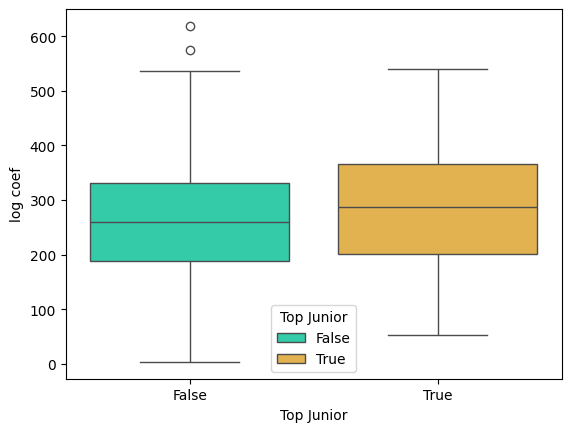

In [103]:
# logarithmic regression of player rating graph, returns a, b in aln(bx)
def fit_log_reg(player, n_tours=0, plot=False):
    rhist = history[history['Database#'] == player['Database#']].reset_index(drop=True)
    data = rhist[['Days Played', 'Initial Rating']]
    data = data[-n_tours:]

    reg = LinearRegression()
    reg.fit(np.log(data[['Days Played']] + 10), data['Initial Rating'])

    a = reg.coef_
    b = np.exp(reg.intercept_ / reg.coef_)
    if plot:
        x = np.arange(0,data['Days Played'].max(),10)
        y = a * np.log(b * (x + 10))
        data.plot(kind='line', x='Days Played', y='Initial Rating')
        plt.plot(x, y)
        plt.ylim(0, None)
        plt.show()
    
    return np.concatenate((a, b))

log_reg = players.apply(fit_log_reg, args=(10, False), axis=1).to_list()
all_a = [coef[0] for coef in log_reg]
all_b = [coef[1] for coef in log_reg]
players['log coef'] = all_a
players['log const'] = all_b

sns.boxplot(data=players, x='Top Junior', y='log coef', hue='Top Junior', palette='turbo')

C:\Users\hsu_s\AppData\Local\Temp\ipykernel_2844\2660846870.py:15: RuntimeWarning: overflow encountered in exp
  b = np.exp(reg.intercept_ / reg.coef_)


<Axes: xlabel='Top Junior', ylabel='rolling log coef'>

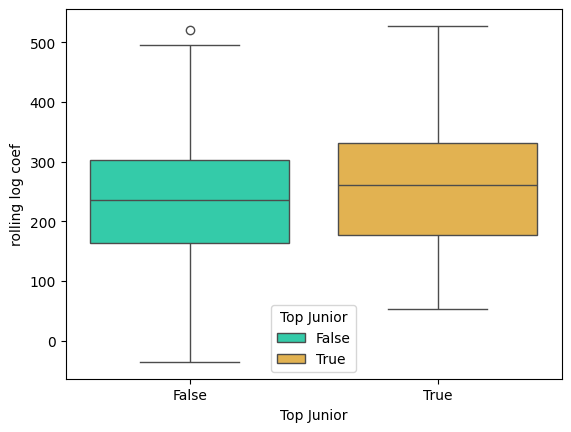

In [104]:
# logarithmic regression of 90 day window moving average of player rating graph, returns a, b in aln(bx)
def fit_rolling_log_reg(player, window=90, n_tours=0, plot=False):
    fullhist = history[history['Database#'] == player['Database#']].reset_index(drop=True)
    rhist = fullhist[['Days Played', 'Initial Rating']]
    rhist['Days Played'] = pd.to_timedelta(rhist['Days Played'], 'day')
    rhist.set_index('Days Played', inplace=True)
    data = rhist.rolling(f'{window}d').mean().reset_index()
    data['Days Played'] = data['Days Played'].dt.days
    data = data[-n_tours:]

    reg = LinearRegression()
    reg.fit(np.log(data[['Days Played']] + 10), data['Initial Rating'])

    a = reg.coef_
    b = np.exp(reg.intercept_ / reg.coef_)
    if plot:
        x = np.arange(0,data['Days Played'].max(),10)
        y = a * np.log(b * (x + 10))
        data.plot(kind='line', x='Days Played', y='Initial Rating')
        plt.plot(x, y)
        plt.ylim(0, None)
        plt.show()
    
    return np.concatenate((a, b))

rolling_log_reg = players.apply(fit_rolling_log_reg, args=(90, 10, False), axis=1).to_list()
rolling_all_a = [coef[0] for coef in rolling_log_reg]
rolling_all_b = [coef[1] for coef in rolling_log_reg]
players['rolling log coef'] = rolling_all_a
players['rolling log const'] = rolling_all_b

sns.boxplot(data=players, x='Top Junior', y='rolling log coef', hue='Top Junior', palette='turbo')

In [105]:
topjuniorcoef = players[players['Top Junior']]['log coef']
nottopjuniorcoef = players[~players['Top Junior']]['log coef']
ttest = ss.ttest_ind(topjuniorcoef, nottopjuniorcoef, alternative='greater')

print('log coef stats:')
print(f'mu 1: {topjuniorcoef.mean()}')
print(f'mu 2: {nottopjuniorcoef.mean()}')
print(f's 1: {topjuniorcoef.std()}')
print(f's 2: {nottopjuniorcoef.std()}')
print(f'n 1: {topjuniorcoef.count()}')
print(f'n 2: {nottopjuniorcoef.count()}')
print(f't stat: {ttest.statistic}')
print(f'p value: {ttest.pvalue}')
print(f'degrees of freedom: {ttest.df}')
print('\n')

topjuniorcoef = players[players['Top Junior']]['rolling log coef']
nottopjuniorcoef = players[~players['Top Junior']]['rolling log coef']
ttest = ss.ttest_ind(topjuniorcoef, nottopjuniorcoef, alternative='greater')

print('rolling log coef stats:')
print(f'mu 1: {topjuniorcoef.mean()}')
print(f'mu 2: {nottopjuniorcoef.mean()}')
print(f's 1: {topjuniorcoef.std()}')
print(f's 2: {nottopjuniorcoef.std()}')
print(f'n 1: {topjuniorcoef.count()}')
print(f'n 2: {nottopjuniorcoef.count()}')
print(f't stat: {ttest.statistic}')
print(f'p value: {ttest.pvalue}')
print(f'degrees of freedom: {ttest.df}')

log coef stats:
mu 1: 280.5784306361413
mu 2: 260.4940664346093
s 1: 115.50644410078284
s 2: 107.67467398647862
n 1: 95
n 2: 526
t stat: 1.6543904597688335
p value: 0.04927757247867601
degrees of freedom: 619.0


rolling log coef stats:
mu 1: 256.22276814924965
mu 2: 231.33514307898642
s 1: 109.43695757905047
s 2: 103.74219921359361
n 1: 95
n 2: 526
t stat: 2.1337755808324643
p value: 0.01662680202848628
degrees of freedom: 619.0


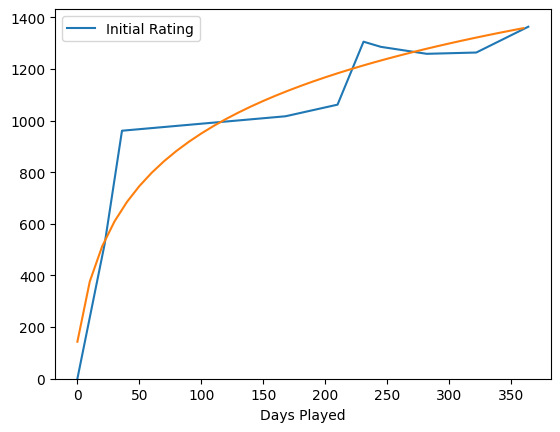

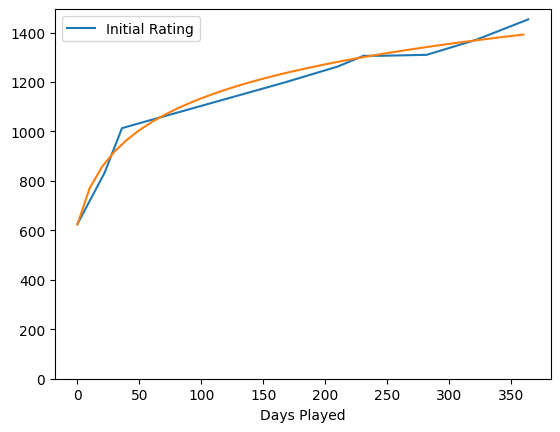

array([212.54190179,   1.88521084])

In [106]:
fit_log_reg(players[players['Database#'] == 102103].iloc[0], n_tours=10, plot=True)
fit_rolling_log_reg(players[players['Database#'] == 102103].iloc[0], window=180, n_tours=10, plot=True)

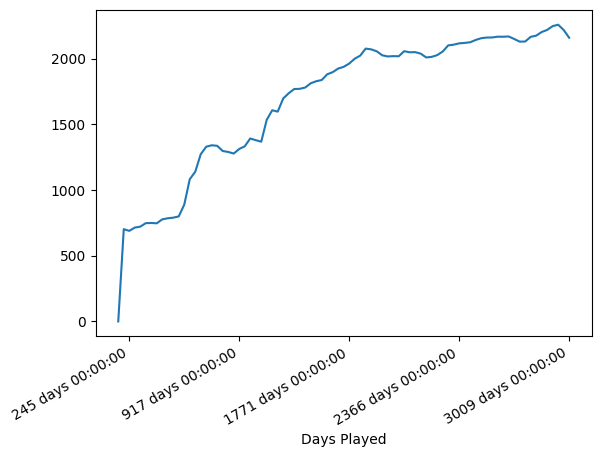

In [15]:
mehist = history[history['Database#'] == 6040]
rhist = mehist['Initial Rating']
rhist.index = pd.to_timedelta(mehist['Days Played'], 'day')

rhist.rolling('90d').mean().plot(kind='line', x='Days Played', y='Initial Rating').invert_xaxis()
# rhist.plot(kind='line', x='Days Played', y='Initial Rating')